In [ ]:
import numpy as np
import pandas as pd
import time, re

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.layers import Dropout, Activation, MaxPooling1D, SpatialDropout1D
from keras.layers.embeddings import Embedding

from keras.callbacks import EarlyStopping
from keras import regularizers, optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

#!pip install ktrain
#import ktrain
#from ktrain import text

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Preprocessing**

**Training/Test Set**

In [ ]:
toxic_comments = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/toxic160000.csv')

filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
y = toxic_comments_labels.values

print('X sample:',X[0])
print('y sample:',y[0])

X sample: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren vandalisms just closure on some GAs after voted at New York Dolls FAC And please don remove the template from the talk page since m retired now 
y sample: [0 0 0 0 0 0]


In [ ]:
print('Loading data...')
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Clean text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

# Convert text to integer sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = 50000
maxlen = 150

# Sequences that are shorter than the max length are padded with value
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Loading data...
X_train shape: (106912, 150)
X_test shape: (52659, 150)
y_train shape: (106912, 6)
y_test shape: (52659, 6)


**Out-of-Sample Set**

In [ ]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"it\Õs", "it is", phrase)
    phrase = re.sub(r"don\Õt", "do not", phrase)
    phrase = re.sub(r"isn\Õt", "is not", phrase)
    phrase = re.sub(r"I\Õm", "I am", phrase)
    phrase = re.sub(r"can\Õt", "can not", phrase)
    phrase = re.sub(r"\Õve", "have", phrase)
    return phrase

cols_target = ["target","text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
target_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Data/multilabel_manifesto.csv", encoding="latin-1", header=None, \
                     names=cols_target, usecols=[0,1,2,3,4,5,6,7])
target_df = target_df[["target","text","toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
X_target = target_df["text"].fillna('').tolist()
X_target = [decontracted(str(i)) for i in X_target]
targ_label = target_df["target"].fillna('').tolist()
toxic_target_labels = target_df[["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
y_target = toxic_target_labels.values

print("Target text:",X_target[0])
print("Target label:",y_target[0])

X_oos sample: hate equality, hate tolerance, hate human rights, hate political correctness, hate hypocrisy, hate ignorance, hate enslaving religions and ideologies, hate antidepressants, hate TV soap operas, hate drama shows, hate rap -music, hate mass media, hate censorship, hate political populists, hate religious fanatics, hate moral majority, hate totalitarianism, hate consumerism, hate democracy, hate pacifism, hate state mafia, hate alcoholics, hate TV commercials, hate human race. love existentialism, love self-awareness, love freedom, love justice, love truth, love moral & political philosophy, love personal & social psychology, love evolution science, love political incorrectness, love guns, love shooting, love BDSM, love computers, love internet, love aggressive electronic and industrial rock metal music, love violent movies, love FPS ï¿½computer games, love sarcasm, love irony, love black humour, love macabre artm mass serial killer cases, love natural disasters, love eugeni

In [ ]:
print("Loading data...")
# Balance classes 
class_weights = compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))

# Change for each model and iteration!
seed = np.random.seed(7)

# Further clean text
tokenizer.fit_on_texts(X_target)

# Split data
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_target, y_target, test_size=0.33, random_state=seed)

# Convert text to integer sequences
X_train_B = tokenizer.texts_to_sequences(X_train_B)
X_test_B = tokenizer.texts_to_sequences(X_test_B)

# Sequences that are shorter than the max length are padded with value
X_train_B = pad_sequences(X_train_B, padding='post', maxlen=maxlen)
X_test_B = pad_sequences(X_test_B, padding='post', maxlen=maxlen)

print('X_train shape:', X_train_B.shape)
print('X_test shape:', X_test_B.shape)

print('y_train shape:', y_train_B.shape)
print('y_test shape:', y_test_B.shape)

Loading data...
X_train shape: (569, 150)
X_test shape: (281, 150)
y_train shape: (569, 6)
y_test shape: (281, 6)


# **Embeddings**

**GloVe**

In [ ]:
glove_path = "/content/gdrive/My Drive/Colab Notebooks/Data/glove.twitter.27B/glove.twitter.27B.50d.txt"

embeddings_index = dict()
with open(glove_path,
          encoding="utf8") as glove:
  for line in glove:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
  glove.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# **Algorithms**

**Attention**

In [ ]:
from keras.engine import Layer, InputSpec
from keras import backend as K
from keras import initializers
from keras import regularizers
from keras import constraints


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):


        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)


    def call(self, x):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.softmax(ait)
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def acc(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "acc":acc}

# **Baseline**

**MultinomialNB for Multilabel (6-Label) Classification**

In [ ]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_oos, y_oos, test_size=0.33, random_state=42, shuffle=True)

# Combine a text feature extractor with multilabel classifier
NB_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
])

NB_pipeline.fit(X_train_B, y_train_B)
NB_pred = NB_pipeline.predict(X_test_B)
cm = multilabel_confusion_matrix(y_test_B, NB_pred) 
print("Accuracy: %s" % NB_pipeline.score(X_test_B, y_test_B))
print("Confusion Matrix:\n %s" % cm)
print("AUC %s" % roc_auc_score(y_test_B, NB_pred))

Accuracy: 0.6334519572953736
Confusion Matrix:
 [[[215   0]
  [ 65   1]]

 [[249   0]
  [ 32   0]]

 [[249   0]
  [ 32   0]]

 [[232   0]
  [ 49   0]]

 [[238   0]
  [ 43   0]]

 [[248   0]
  [ 33   0]]]
AUC 0.5012626262626263


# **TextCNN**

**Pipeline**

In [ ]:
%%time

#Parameters
maxlen = maxlen
num_filters = 32
weight_decay = 1e-4
embedding_dim = 50
batch_size = 128
pool_size = 2
epochs = 20

print('Build CNN model...')
model = Sequential()
# First layer
model.add(Embedding(vocab_size, embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='valid'))
model.add(MaxPooling1D(pool_size=pool_size))
# Second layer
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=pool_size))
# Third layer
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Flatten())
# CLASSIFICATION
# Fully connected layer
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.2))
# Output layer w/ sigmoid
model.add(Dense(6, activation='sigmoid'))

# Compile the model
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

cnn_history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks)

model.save('my_cnn.h5')

Build CNN model...
Epoch 1/20
106912/106912 [==============================] - 27s 249us/step - loss: 0.1360 - acc: 0.9636
Epoch 2/20
  2560/106912 [..............................] - ETA: 6s - loss: 0.1037 - acc: 0.9691

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


106912/106912 [==============================] - 7s 63us/step - loss: 0.1035 - acc: 0.9688
Epoch 3/20
106912/106912 [==============================] - 7s 65us/step - loss: 0.0949 - acc: 0.9710
Epoch 4/20
106912/106912 [==============================] - 7s 65us/step - loss: 0.0907 - acc: 0.9722
Epoch 5/20
106912/106912 [==============================] - 7s 63us/step - loss: 0.0869 - acc: 0.9729
Epoch 6/20
106912/106912 [==============================] - 7s 64us/step - loss: 0.0845 - acc: 0.9734
Epoch 7/20
106912/106912 [==============================] - 7s 63us/step - loss: 0.0830 - acc: 0.9741
Epoch 8/20
106912/106912 [==============================] - 7s 63us/step - loss: 0.0817 - acc: 0.9743
Epoch 9/20
106912/106912 [==============================] - 7s 63us/step - loss: 0.0800 - acc: 0.9747
Epoch 10/20
106912/106912 [==============================] - 7s 62us/step - loss: 0.0787 - acc: 0.9752
Epoch 11/20
106912/106912 [==============================] - 7s 63us/step - loss: 0.0776 - a

**Retraining**

In [ ]:
cnn_model_A = load_model('my_cnn.h5')

cnn_model_B_on_A = Sequential(cnn_model_A.layers[:-1])
cnn_model_B_on_A.add(Dense(6, activation="sigmoid"))

for layer in cnn_model_B_on_A.layers[:-1]:
    trainable = True

adam = optimizers.Adam(lr=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cnn_model_B_on_A.compile(loss="binary_crossentropy", optimizer=adam,
                     metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

cnn_B_history = cnn_model_B_on_A.fit(X_train_B, y_train_B, epochs=20,
                           validation_data=(X_test_B, y_test_B),
                           batch_size=32,
                           callbacks=callbacks)

loss, acc = model.evaluate(X_train_B, y_train_B, verbose=True)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(X_test_B, y_test_B, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))

cnn_model_B_on_A.save('my_cnn_B.h5')

Train on 569 samples, validate on 281 samples
Epoch 1/20
569/569 [==============================] - 23s 41ms/step - loss: 0.5038 - acc: 0.8149 - val_loss: 0.4364 - val_acc: 0.8286
Epoch 2/20
569/569 [==============================] - 0s 307us/step - loss: 0.4192 - acc: 0.8333 - val_loss: 0.4017 - val_acc: 0.8292
Epoch 3/20
569/569 [==============================] - 0s 289us/step - loss: 0.3835 - acc: 0.8374 - val_loss: 0.3788 - val_acc: 0.8321
Epoch 4/20
569/569 [==============================] - 0s 332us/step - loss: 0.3618 - acc: 0.8433 - val_loss: 0.3672 - val_acc: 0.8357
Epoch 5/20
569/569 [==============================] - 0s 298us/step - loss: 0.3413 - acc: 0.8559 - val_loss: 0.3685 - val_acc: 0.8399
Epoch 6/20
569/569 [==============================] - 0s 307us/step - loss: 0.3220 - acc: 0.8597 - val_loss: 0.3647 - val_acc: 0.8416
Epoch 7/20
569/569 [==============================] - 9s 15ms/step
Training Accuracy: 0.8363
Testing Accuracy:  0.8327


**Evaluation**

In [ ]:
cnn_model_B = load_model('my_cnn_B.h5')

# Probability predictions of labels
y_pred = cnn_model_B.predict(X_test_B)

# Show the inputs and predicted outputs
for i in range(5):
  print("X=%s\n Predicted=%s\n" % (tokenizer.sequences_to_texts(X_test_B)[i], y_pred[i]))

X=they for make an except to avoid situation guys for not tagged this to the awards has that detail this that just negative no the elvis to the nonetheless if not or it adminship change if or image without of them for own just is source the obviously and the his discussion for not legal after it wrong www dropped to on of composer adults just is tendency of they for because into like from site for will not for haven have of for are to rvv an it an wanting all make penis government to insert make section source the his
 Predicted=[0.24200931 0.10111693 0.05809367 0.1396718  0.1226202  0.15338951]

X=be minds with wales of many this the favor and the his of the small com to to the verifiable nhrhs pursue improved and the live in it people state his style fi primary your design on of in blocked primary the effort few and century be celebrity the quickly and the his to system of to kingdom notion in me topic whatever on what is his style of be celebrity so to editors dealing believe have t

In [ ]:
def convert_pred(pred_tensor):
  with np.nditer(pred_tensor, op_flags=['readwrite']) as it:
    for x in it:
      if x >= 0.1:
        x[...] = 1
      else:
        x[...] = 0
  return pred_tensor

cnn_predict_fit = convert_pred(y_pred).astype('int32')

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
print("ROC score: %s" % roc_auc_score(y_test_B, cnn_predict_fit))
print("AP score: %s\n" % average_precision_score(y_test_B, cnn_predict_fit))
print("Confusion Matrix:\n %s" % multilabel_confusion_matrix(y_test_B, cnn_predict_fit))

ROC score: 0.7222756689525167
AP score: 0.29793119942582685

Confusion Matrix:
 [[[ 82 118]
  [  1  80]]

 [[223  26]
  [ 13  19]]

 [[179  74]
  [  6  22]]

 [[143  86]
  [ 13  39]]

 [[165  68]
  [ 11  37]]

 [[169  64]
  [ 14  34]]]


In [ ]:
multilabels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print('----------------------EVALUATION----------------------\n')
print(classification_report(y_test_B, cnn_predict_fit, labels=(0,1,2,3,4,5), target_names=multilabels))

----------------------EVALUATION----------------------

               precision    recall  f1-score   support

        toxic       0.41      0.89      0.56        81
 severe_toxic       0.26      0.56      0.36        32
      obscene       0.23      0.75      0.36        28
       threat       0.35      0.79      0.48        52
       insult       0.34      0.71      0.46        48
identity_hate       0.25      0.52      0.33        48

    micro avg       0.32      0.73      0.45       289
    macro avg       0.31      0.70      0.43       289
 weighted avg       0.33      0.73      0.45       289
  samples avg       0.20      0.31      0.22       289



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# **BiLSTM**

**Pipeline**

In [ ]:
%%time

#Parameters
maxlen = maxlen
lstm_output_size = 64
embedding_dim = 50
batch_size = 256
epochs = 5

print('Build LSTM model...')
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(lstm_output_size, dropout=0.2, recurrent_dropout=0.2)))
# Output layer w/ sigmoid
model.add(Dense(6, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

lstm_history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=(X_test, y_test))

model.save('my_lstm.h5')

Build LSTM model...
Train on 106912 samples, validate on 52659 samples
Epoch 1/5
106912/106912 [==============================] - 278s 3ms/step - loss: 0.1552 - acc: 0.9577 - val_loss: 0.1255 - val_acc: 0.9630
Epoch 2/5
106912/106912 [==============================] - 252s 2ms/step - loss: 0.1159 - acc: 0.9650 - val_loss: 0.1045 - val_acc: 0.9672
Epoch 3/5
106912/106912 [==============================] - 252s 2ms/step - loss: 0.1063 - acc: 0.9671 - val_loss: 0.0984 - val_acc: 0.9690
Epoch 4/5
106912/106912 [==============================] - 252s 2ms/step - loss: 0.1001 - acc: 0.9689 - val_loss: 0.0922 - val_acc: 0.9707
Epoch 5/5
106912/106912 [==============================] - 249s 2ms/step - loss: 0.0959 - acc: 0.9702 - val_loss: 0.0871 - val_acc: 0.9726
CPU times: user 33min 35s, sys: 4min 35s, total: 38min 11s
Wall time: 22min 17s


**Retraining**

In [ ]:
lstm_model_A = load_model("my_lstm.h5")

lstm_model_B_on_A = Sequential(lstm_model_A.layers[:-1])
lstm_model_B_on_A.add(Dense(6, activation="sigmoid"))

for layer in lstm_model_B_on_A.layers[:-1]:
    trainable = True

adam = optimizers.Adam(lr=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
lstm_model_B_on_A.compile(loss="binary_crossentropy", optimizer=adam,
                     metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

lstm_B_history = lstm_model_B_on_A.fit(X_train_B, y_train_B, epochs=20,
                           validation_data=(X_test_B, y_test_B),
                           batch_size=32,
                           callbacks=callbacks)

loss, acc = model.evaluate(X_train_B, y_train_B, verbose=True)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(X_test_B, y_test_B, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))

lstm_model_B_on_A.save("my_lstm_B.h5")

Train on 569 samples, validate on 281 samples
Epoch 1/20
569/569 [==============================] - 37s 65ms/step - loss: 0.7270 - acc: 0.5360 - val_loss: 0.5310 - val_acc: 0.8286
Epoch 2/20
569/569 [==============================] - 11s 19ms/step - loss: 0.4772 - acc: 0.8319 - val_loss: 0.4419 - val_acc: 0.8286
Epoch 3/20
569/569 [==============================] - 11s 19ms/step - loss: 0.4346 - acc: 0.8336 - val_loss: 0.4330 - val_acc: 0.8286
Epoch 4/20
569/569 [==============================] - 11s 19ms/step - loss: 0.4255 - acc: 0.8336 - val_loss: 0.4286 - val_acc: 0.8286
Epoch 5/20
569/569 [==============================] - 11s 19ms/step - loss: 0.4199 - acc: 0.8336 - val_loss: 0.4192 - val_acc: 0.8286
Epoch 6/20
569/569 [==============================] - 11s 19ms/step - loss: 0.4128 - acc: 0.8342 - val_loss: 0.4175 - val_acc: 0.8286
Epoch 7/20
569/569 [==============================] - 11s 20ms/step - loss: 0.4112 - acc: 0.8348 - val_loss: 0.4098 - val_acc: 0.8304
Epoch 8/20
569/5

**Evaluation**

In [ ]:
lstm_model_B = load_model('my_lstm_B.h5')

# Probability predictions of labels
y_pred = lstm_model_B.predict(X_test_B)

# Show the inputs and predicted outputs
for i in range(5):
  print("X=%s\n Predicted=%s\n" % (tokenizer.sequences_to_texts(X_test_B)[i], y_pred[i]))

X=when you take your case to washington d c you are taking it to the criminal who is responsible it is like running from the wolf to the fox they are all in cahoots together they all work political chicanery and make you look like a chump before the eyes of the world here you are walking around in america getting ready to be drafted and sent abroad like a tin soldier and when you get over there people ask you what are you fighting for and you have to stick your tongue in your cheek no take uncle sam to court take him before the world
 Predicted=[0.44167832 0.18228698 0.14604259 0.2972779  0.33124894 0.26217866]

X=we invite this congress and through it the scientists of the world and the general public to subscribe to the following resolution ï¿½in view of the fact that in any future world war nuclear weapons will certainly be employed and that such weapons threaten the continued existence of mankind we urge the governments of the world to realize and to acknowledge publicly that their

In [ ]:
def convert_pred(pred_tensor):
  with np.nditer(pred_tensor, op_flags=['readwrite']) as it:
    for x in it:
      if x >= 0.4:
        x[...] = 1
      else:
        x[...] = 0
  return pred_tensor

lstm_predict_fit = convert_pred(y_pred).astype('int32')

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
print("ROC score: %s" % roc_auc_score(y_test_B, y_pred))
print("AP score: %s\n" % average_precision_score(y_test_B, y_pred))

multilabels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print('----------------------EVALUATION----------------------\n')
print(classification_report(y_test_B, lstm_predict_fit, labels=(0,1,2,3,4,5), target_names=multilabels))

ROC score: 0.6509899713772902
AP score: 0.3009683484291788

Confusion Matrix:
 [[[181  19]
  [ 60  21]]

 [[232  17]
  [ 17  15]]

 [[236  17]
  [  7  21]]

 [[208  21]
  [ 37  15]]

 [[207  26]
  [ 25  23]]

 [[233   0]
  [ 48   0]]]


# **BiLSTM w/ Attention**

**Pipeline**

In [ ]:
%%time

#Parameters
maxlen = maxlen
num_filters = 64
lstm_output_size = 128
weight_decay = 1e-4
embedding_dim = 50
batch_size = 128
kernel_size = 4
pool_size = 4
epochs = 5

print('Build ATT model...')
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(num_filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Bidirectional(LSTM(lstm_output_size, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(AttentionWithContext())
# Output layer w/ sigmoid
model.add(Dense(6, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

att_history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=(X_test, y_test))

model.save('my_att.h5')

Build ATT model...
Train on 106912 samples, validate on 52659 samples
Epoch 1/5
106912/106912 [==============================] - 166s 2ms/step - loss: 0.1215 - acc: 0.9651 - val_loss: 0.0972 - val_acc: 0.9702
Epoch 2/5
106912/106912 [==============================] - 137s 1ms/step - loss: 0.0946 - acc: 0.9709 - val_loss: 0.0888 - val_acc: 0.9725
Epoch 3/5
106912/106912 [==============================] - 136s 1ms/step - loss: 0.0870 - acc: 0.9731 - val_loss: 0.0836 - val_acc: 0.9741
Epoch 4/5
106912/106912 [==============================] - 137s 1ms/step - loss: 0.0831 - acc: 0.9739 - val_loss: 0.0823 - val_acc: 0.9745
Epoch 5/5
106912/106912 [==============================] - 136s 1ms/step - loss: 0.0805 - acc: 0.9745 - val_loss: 0.0780 - val_acc: 0.9753
CPU times: user 17min 59s, sys: 2min 5s, total: 20min 4s
Wall time: 12min 57s


**Retraining**

In [ ]:
att_model_A = load_model('my_att.h5', custom_objects=create_custom_objects())

att_model_B_on_A = Sequential(att_model_A.layers[:-1])
att_model_B_on_A.add(Dense(6, activation="sigmoid"))

for layer in lstm_model_B_on_A.layers[:-1]:
    trainable = True

adam = optimizers.Adam(lr=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
att_model_B_on_A.compile(loss="binary_crossentropy", optimizer=adam,
                     metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0)
callbacks = [early_stopping]

att_B_history = att_model_B_on_A.fit(X_train_B, y_train_B, epochs=20,
                           validation_data=(X_test_B, y_test_B),
                           callbacks=callbacks)

loss, acc = model.evaluate(X_train_B, y_train_B, verbose=True)
print("Training Accuracy: {:.4f}".format(acc))
loss, acc = model.evaluate(X_test_B, y_test_B, verbose=False)
print("Testing Accuracy:  {:.4f}".format(acc))

att_model_B_on_A.save('my_att_B.h5')

**Evaluation**

In [ ]:
att_model_B = load_model('my_att_B.h5', custom_objects=create_custom_objects())

# Probability predictions of labels
y_pred = att_model_B.predict(X_test_B)

# Show the inputs and predicted outputs
for i in range(5):
  print("X=%s\n Predicted=%s\n" % (tokenizer.sequences_to_texts(X_test_B)[i], y_pred[i]))

X=when you take your case to washington d c you are taking it to the criminal who is responsible it is like running from the wolf to the fox they are all in cahoots together they all work political chicanery and make you look like a chump before the eyes of the world here you are walking around in america getting ready to be drafted and sent abroad like a tin soldier and when you get over there people ask you what are you fighting for and you have to stick your tongue in your cheek no take uncle sam to court take him before the world
 Predicted=[0.26227805 0.06249803 0.03448489 0.14164007 0.09361386 0.13231012]

X=we invite this congress and through it the scientists of the world and the general public to subscribe to the following resolution ï¿½in view of the fact that in any future world war nuclear weapons will certainly be employed and that such weapons threaten the continued existence of mankind we urge the governments of the world to realize and to acknowledge publicly that their

In [ ]:
def convert_pred(pred_tensor):
  with np.nditer(pred_tensor, op_flags=['readwrite']) as it:
    for x in it:
      if x >= 0.1:
        x[...] = 1
      else:
        x[...] = 0
  return pred_tensor

att_predict_fit = convert_pred(y_pred).astype('int32')

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
print("ROC score: %s" % roc_auc_score(y_test_B, att_predict_fit))
print("AP score: %s\n" % average_precision_score(y_test_B, att_predict_fit))
print("Confusion Matrix:\n %s" % multilabel_confusion_matrix(y_test_B, att_predict_fit))

ROC score: 0.5393584091257911
AP score: 0.16550538048559946

Confusion Matrix:
 [[[ 65 140]
  [ 16  60]]

 [[200  59]
  [ 19   3]]

 [[204  46]
  [ 24   7]]

 [[120 113]
  [ 17  31]]

 [[139 100]
  [ 20  22]]

 [[114 132]
  [ 11  24]]]


In [ ]:
multilabels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print('----------------------EVALUATION----------------------\n')
print(classification_report(y_test_B, att_predict_fit, labels=(0,1,2,3,4,5), target_names=multilabels))

----------------------EVALUATION----------------------

               precision    recall  f1-score   support

        toxic       0.40      0.99      0.57        81
 severe_toxic       0.42      0.59      0.49        32
      obscene       0.23      0.79      0.35        28
       threat       0.31      0.75      0.44        52
       insult       0.35      0.77      0.48        48
identity_hate       0.35      0.71      0.47        48

    micro avg       0.35      0.80      0.48       289
    macro avg       0.34      0.77      0.47       289
 weighted avg       0.35      0.80      0.49       289
  samples avg       0.22      0.34      0.25       289



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# **BERT**

In [ ]:
toxic_path = '/content/gdrive/My Drive/Colab Notebooks/Data/bert_multilabel.csv'
label_columns = ["toxic", "severe_toxic", "obscene", 
                 "threat", "insult", "identity_hate"]

(X_train_bert, y_train_bert), (X_test_bert, y_test_bert), preproc = text.texts_from_csv(toxic_path, "text",
                                                                    label_columns=label_columns, 
                                                                    max_features=vocab_size, 
                                                                    maxlen=maxlen,
                                                                    preprocess_mode="bert")

detected encoding: utf-8 (if wrong, set manually)
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


Is Multi-Label? True
maxlen is 150
done.
simulating training for different learning rates... this may take a few moments...
Train on 765 samples
Epoch 1/1024
765/765 [==============================] - 22s 28ms/sample - loss: 0.9553 - acc: 0.3871
Epoch 2/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.9334 - acc: 0.3926
Epoch 3/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.9006 - acc: 0.4105
Epoch 4/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.8649 - acc: 0.4355
Epoch 5/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.8226 - acc: 0.4667
Epoch 6/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.7755 - acc: 0.4943
Epoch 7/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.7238 - acc: 0.5285
Epoch 8/1024
765/765 [==============================] - 14s 18ms/sample - loss: 0.6704 - acc: 0.5741
Epoch 9/1024
765/765 [=========================

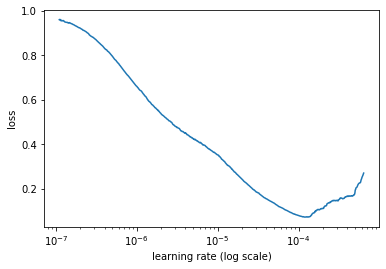

In [ ]:
model = text.text_classifier("bert", (X_train_bert, y_train_bert), preproc=preproc, multilabel=True)
learner = ktrain.get_learner(model, train_data=(X_train_bert, y_train_bert), val_data=(X_test_bert, y_test_bert), batch_size=32)

# find a good learning rate
learner.lr_find()
learner.lr_plot()

# train using triangular learning rate policy
learner.autofit(0.0007, 10)

In [ ]:
#predictor = ktrain.get_predictor(learner.model, preproc)
#bert_pred_prob = predictor.predict_proba(X_test)
bert_pred = learner.model.predict(X_test_bert, verbose=0)

In [ ]:
# Show the inputs and predicted outputs
for i in range(5):
  print("X=%s,\nPredicted=%s" % (tokenizer.sequences_to_texts(X_test_bert)[i],bert_pred[i]))

X=when you take your case to washington d c you are taking it to the criminal who is responsible it is like running from the wolf to the fox they are all in cahoots together they all work political chicanery and make you look like a chump before the eyes of the world here you are walking around in america getting ready to be drafted and sent abroad like a tin soldier and when you get over there people ask you what are you fighting for and you have to stick your tongue in your cheek no take uncle sam to court take him before the world,
Predicted=[0.268759   0.10832    0.1419129  0.16500017 0.1977604  0.16004488]
X=we invite this congress and through it the scientists of the world and the general public to subscribe to the following resolution ï¿½in view of the fact that in any future world war nuclear weapons will certainly be employed and that such weapons threaten the continued existence of mankind we urge the governments of the world to realize and to acknowledge publicly that their 

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
ROC_score = roc_auc_score(y_test_bert, bert_pred)
AP_score = average_precision_score(y_test_bert, bert_pred)
print("\n ROC-AUC score: %.2f \n" % (ROC_score))
print("\n AP score: %.2f \n" % (AP_score))


 ROC-AUC score: 0.65 


 AP score: 0.26 

